## UMAP clustering on re-trained with PIC   
    - 102 epochs initial (kmeans)
    - 15 additional epochs (PIC)
    - train data:
    
    ```
    Haus8 sgRNA #1	190219_195942-V	B12	
    Haus8 sgRNA #2	190219_195942-V	E1	
    Haus8 sgRNA #3	190219_195942-V	F2	
    Haus8 sgRNA #4	190219_195942-V	G2	
    DyncH1 sgRNA #3	190219_195942-V	A1	
    Incenp sgRNA #1	190219_195942-V	G4	
    Incenp sgRNA #2	190219_195942-V	G6	
    Incenp sgRNA #3	190219_195942-V	H1	
    Rad21 sgRNA #1	190219_195942-V	H3	
    Rad21 sgRNA #2	190219_195942-V	H5	
    Rad21 sgRNA #3	190219_195942-V	H7
    ```
    - test: 
    
    ```
    Incenp sgRNA #1	190219_195942-V	G5	
    Incenp sgRNA #2	190219_195942-V	G8	
    No sgRNA Pt11_r01_c12
    ```
    - clustering with UMAP

Additional cluster comparisons

In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

ModuleNotFoundError: No module named 'anndata'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('/home/aogorodnikov/model_alex_pos/checkpoints/checkpoint_14.0.pth.tar')

=> loading checkpoint '/home/aogorodnikov/model_alex_pos/checkpoints/checkpoint_14.0.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [7]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
features = compute_features(dataloader, model, len(dataset))

In [9]:
features.shape

(203428, 4096)

In [10]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [11]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [12]:
%%time 
#pca = PCA(svd_solver='randomized', whiten=True).fit(adata)
sc.tl.pca(adata, n_comps=256, svd_solver='randomized')

CPU times: user 2min 39s, sys: 6.71 s, total: 2min 46s
Wall time: 26.2 s


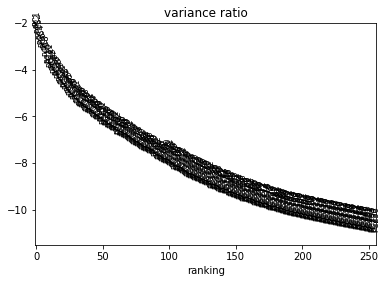

In [13]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=256)


In [14]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=256)

In [15]:
adata

AnnData object with n_obs × n_vars = 203428 × 4096 
    obs: 0, 'well', 'image_ID'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'

In [16]:
sc.tl.umap(adata)

In [17]:
sc.tl.louvain(adata, resolution=1)

In [18]:
sc.tl.leiden(adata, resolution=1)

### Compare cluster sizes between samples  


In [19]:
## louvain
louvain_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.louvain[adata.obs.well == well])
    for i in adata.obs.louvain.unique():
        res = [well, i, len(adata.obs.louvain[(adata.obs.louvain == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        louvain_ls.append(res)

In [20]:
louvain_df = pd.DataFrame(louvain_ls, columns=['well', 'class', 'n_samp'])

In [21]:
louvain_df.head()

well class       n_samp
0  Pt04_r07c05     1  2187.671012
1  Pt04_r07c05     0  2060.035410
2  Pt04_r07c05     2  1716.240142
3  Pt04_r07c05     5   416.224046
4  Pt04_r07c05    10   226.943506

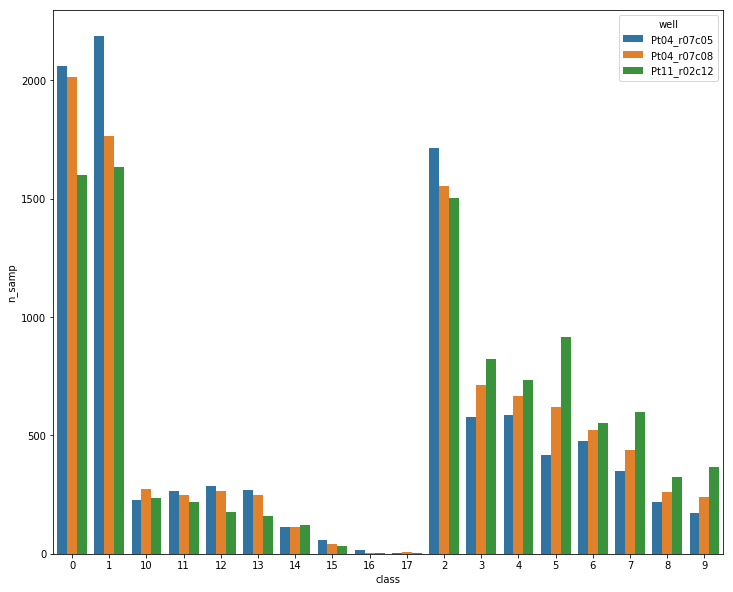

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=louvain_df)

In [23]:
## leiden
leiden_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.leiden[adata.obs.well == well])
    for i in adata.obs.leiden.unique():
        res = [well, i, len(adata.obs.leiden[(adata.obs.leiden == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        leiden_ls.append(res)

In [24]:
leiden_df = pd.DataFrame(leiden_ls, columns=['well', 'class', 'n_samp'])

In [25]:
leiden_df.head()

well class       n_samp
0  Pt04_r07c05     2  1245.131177
1  Pt04_r07c05     4   672.782875
2  Pt04_r07c05     8   414.775471
3  Pt04_r07c05     5   668.115242
4  Pt04_r07c05     0   963.141799

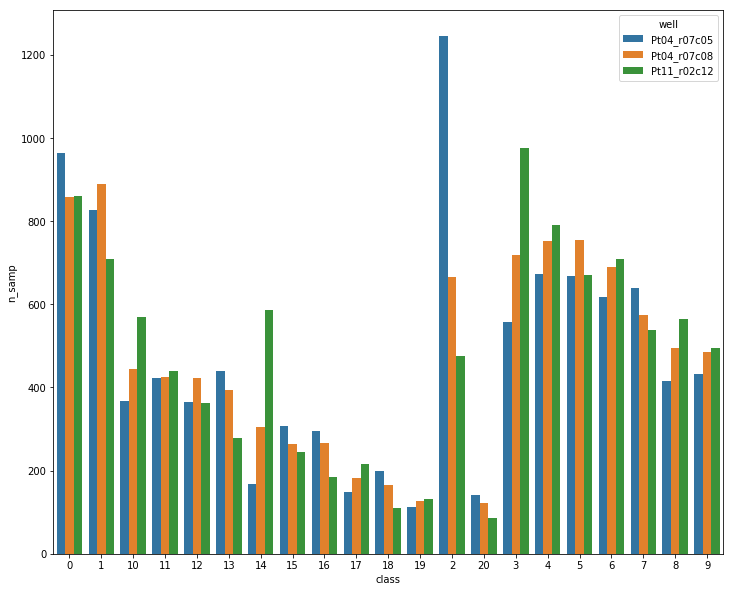

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=leiden_df)

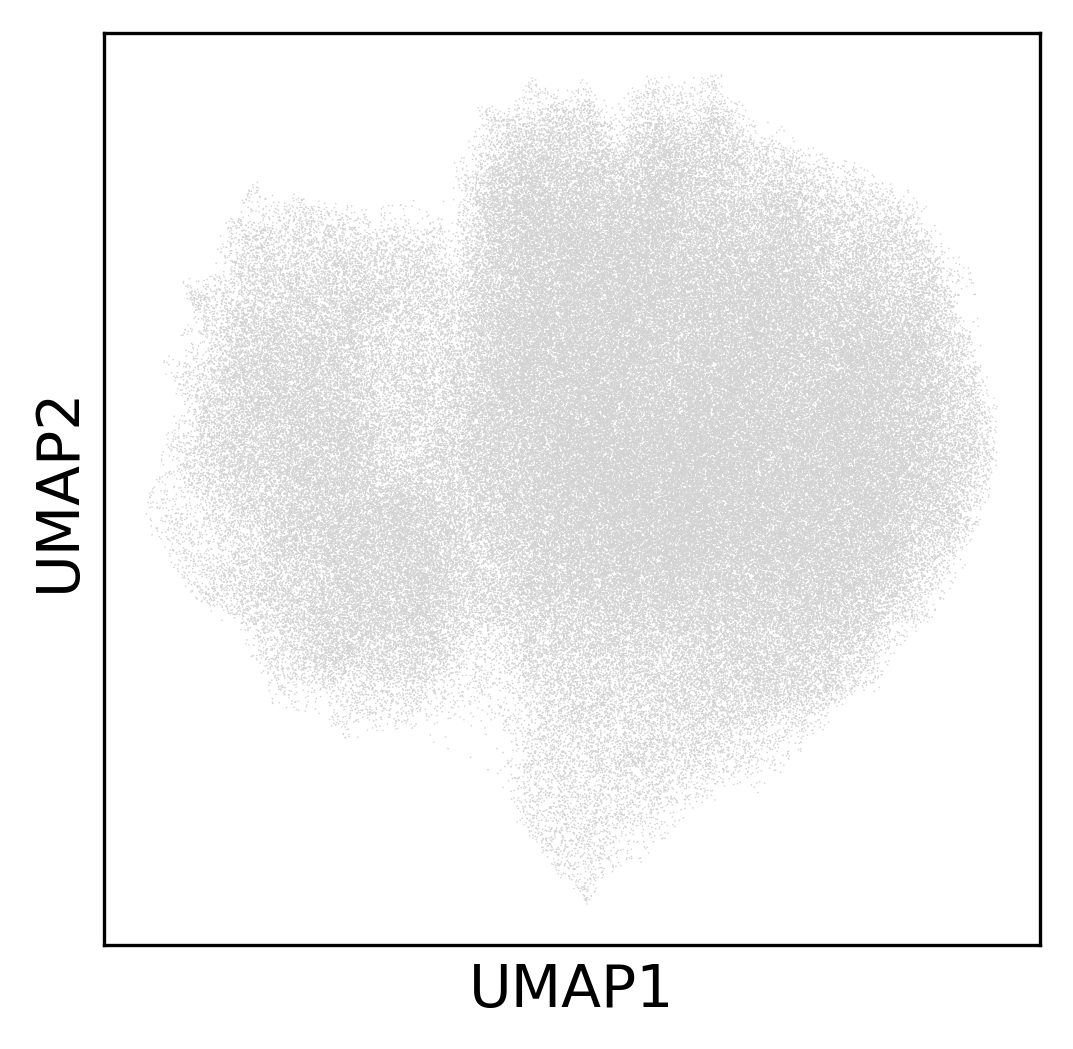

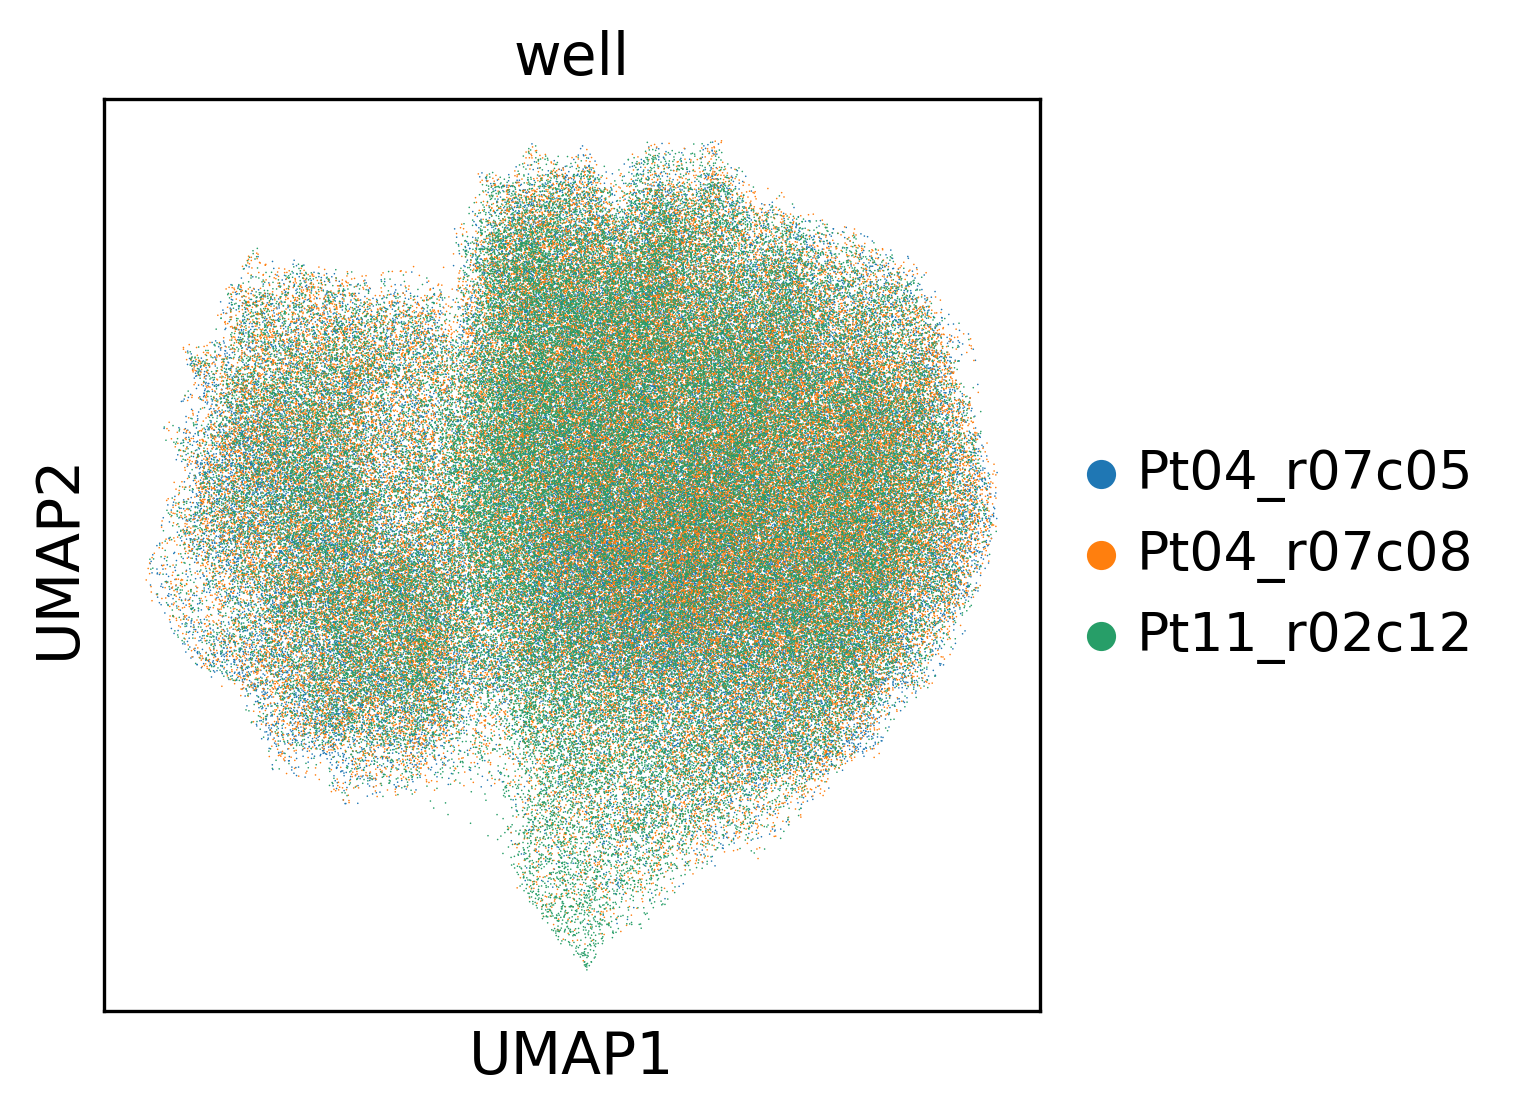

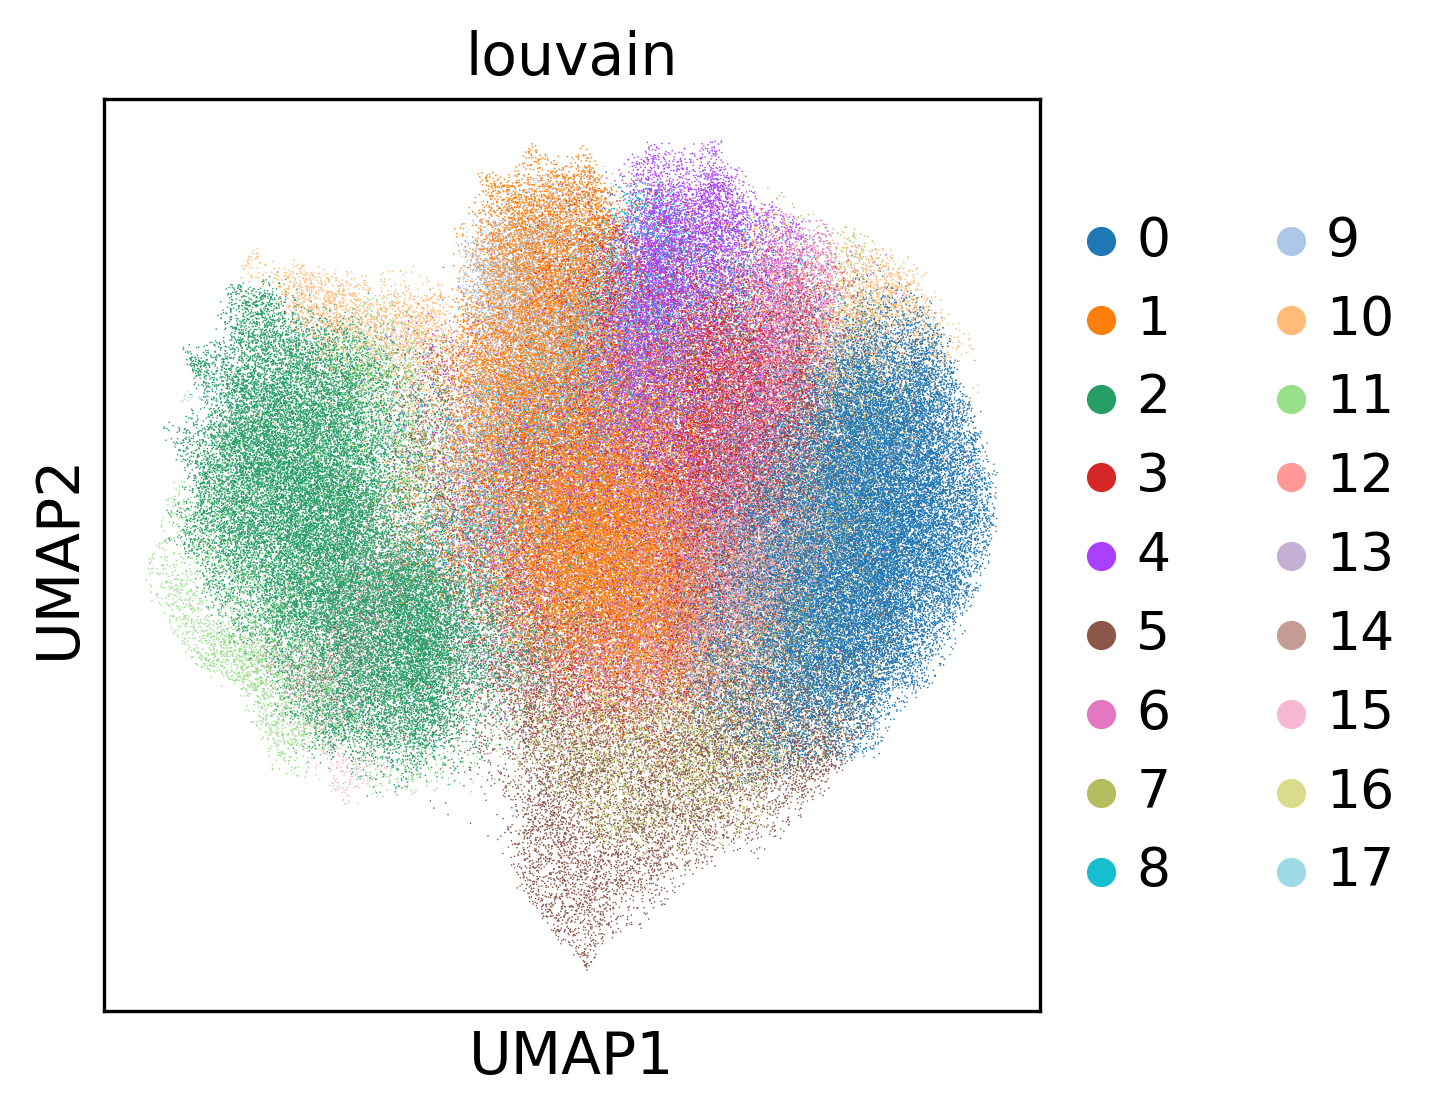

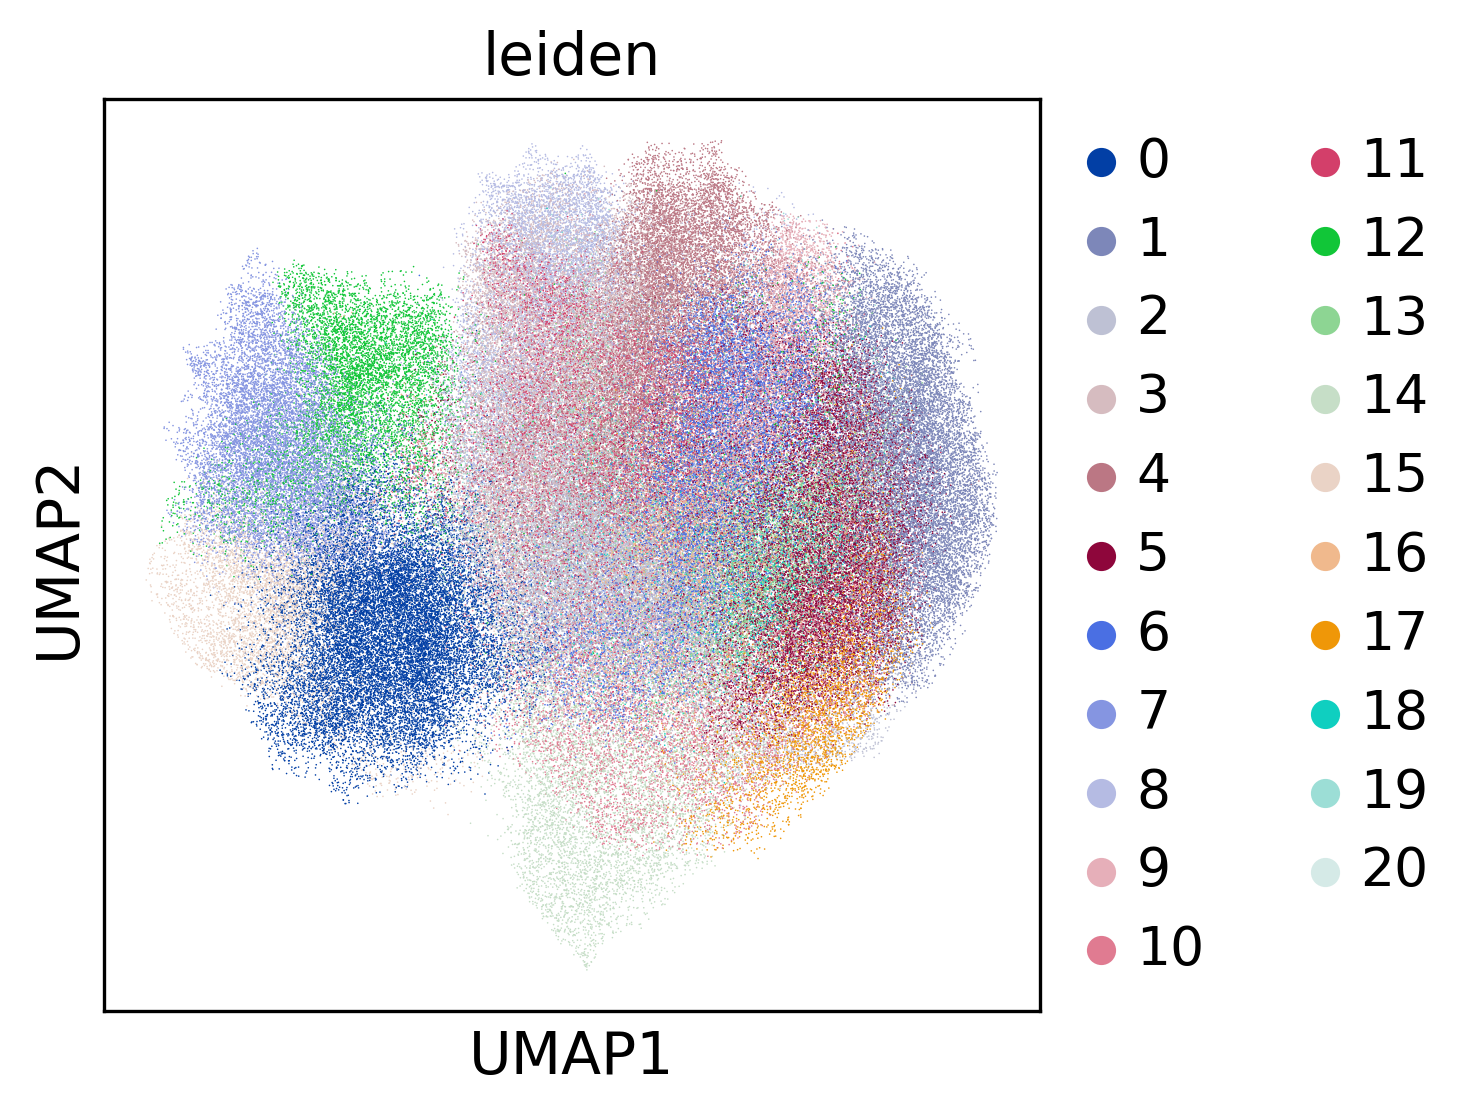

In [44]:
sc.settings.set_figure_params(dpi=150, color_map='viridis')
sc.pl.umap(adata)
sc.pl.umap(adata,color=['well'], use_raw=False)
sc.pl.umap(adata,color=['louvain'], use_raw=False)
sc.pl.umap(adata,color=['leiden'], use_raw=False)

### Clusters to export  
0, 10, 2, 20, 25, 27, 30, 31, 4, 5, 8, 9

In [29]:
import re
import cv2

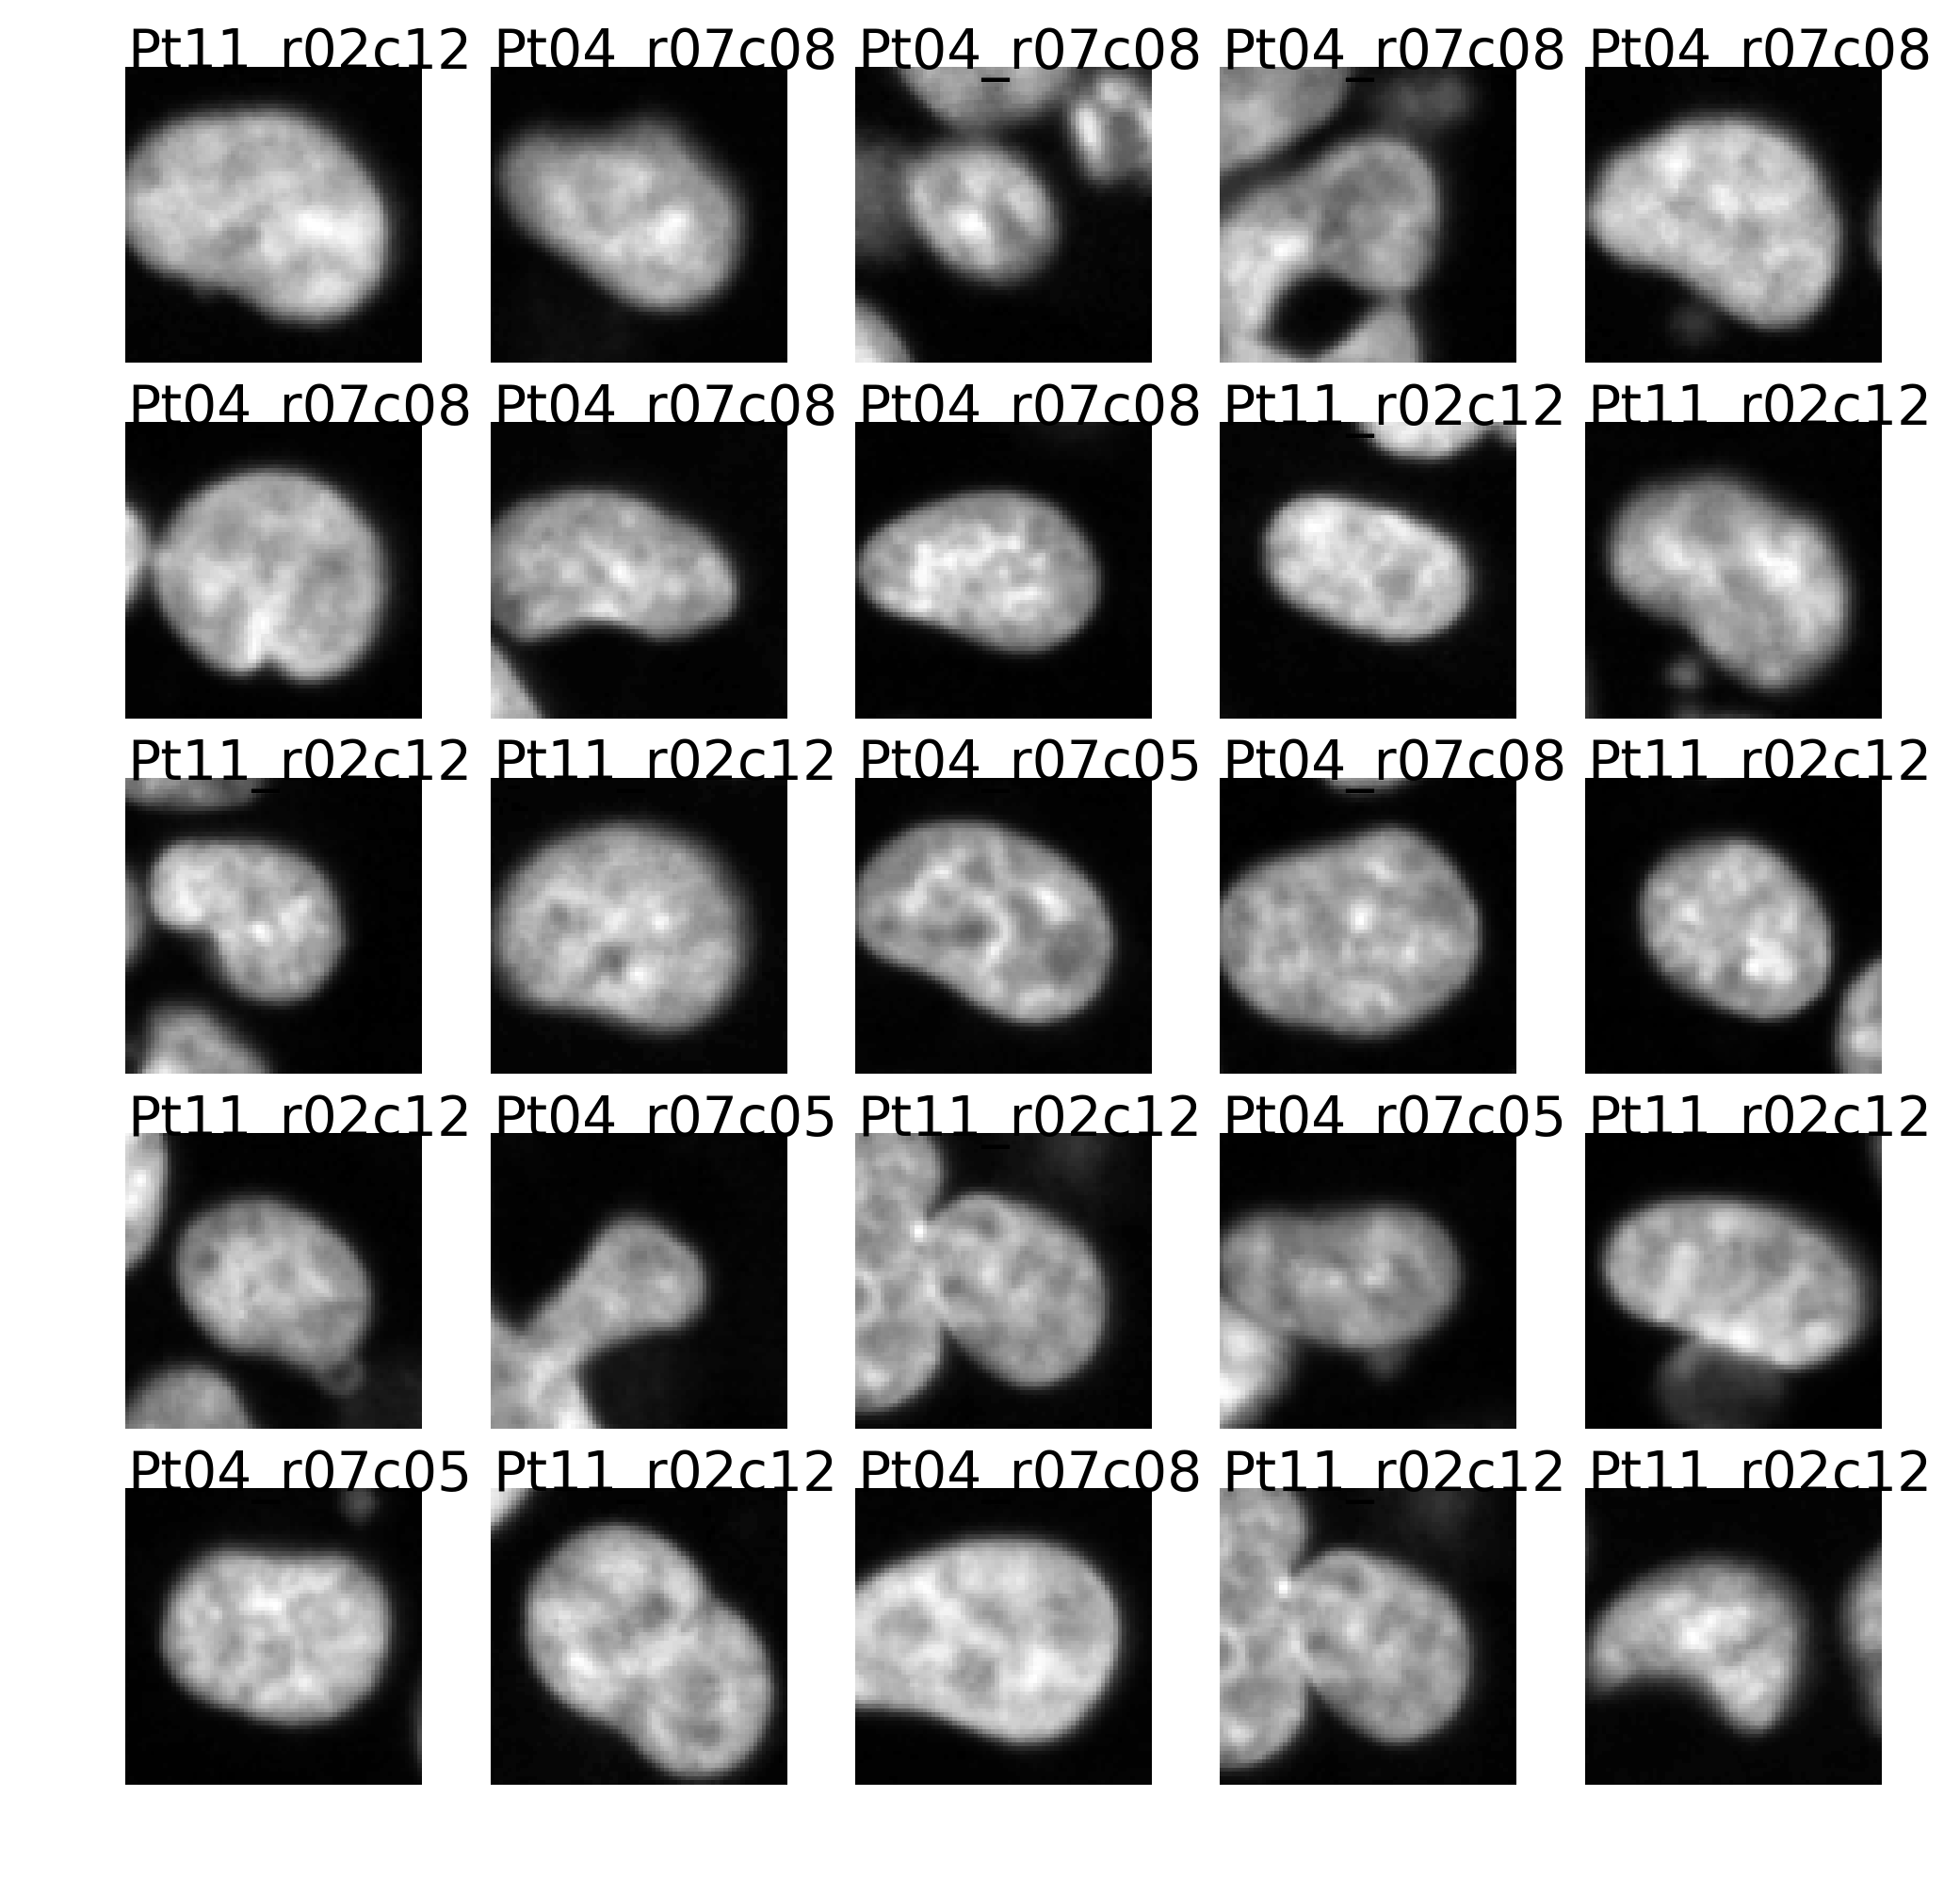

In [85]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = adata.obs.loc[adata.obs.leiden == '20', 0].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread(rand_select, -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

In [36]:
re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0]

'Pt02_r02c01'